# Machine Learning in Python - Workshop 8

# 1. Setup


## 1.1 Packages


In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [22]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.markersize'] = 7.5

# sklearn modules
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

## 1.2 Helper Functions



In [30]:
def plot_margin(model, data, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50):
    # Plot the data
    p = sns.scatterplot(x=x, y=y, hue=cat, data=data, legend=False)
    
    # Find the extent of x and y
    xlim = p.get_xlim()
    ylim = p.get_ylim()
    
    # Create a grid of points
    xx = np.linspace(xlim[0], xlim[1], nx)
    yy = np.linspace(ylim[0], ylim[1], ny)
    YY, XX = np.meshgrid(yy, xx)
    
    # Calculate the label for each point in the grid
    xy = np.c_[XX.ravel(), YY.ravel()]
    Z = model.decision_function(xy).reshape(XX.shape)
    
    # plot contours of decision boundary and margins
    p.contour(XX, YY, Z, colors='k', 
              levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])

    # highlight support vectors
    if (show_support_vectors):
        p.scatter(model.support_vectors_[:, 0], 
                  model.support_vectors_[:, 1], s=100,
                  linewidth=1, facecolors='none', edgecolors='k')

    # Show confusion table in the title
    p.set_title(
        "TN: {0}, FP: {1}, FN: {2}, TP: {3}".format(
            *confusion_matrix(
                data[cat],
                m.predict(data.drop(cat, axis=1))
            ).flatten()
        )
    )
    
    plt.show()

## 1.3 Jupyter Advice

Some of the interactive plots below are large enough that Jupyter will attempt to add a scrollbar which will prevent you from seeing all the options and the plot at the same time. To avoid this you can select Cell -> Current Outputs -> Toggle Scrolling from the Jupyter menu above to remove this scrolling.

--- 

# 2. Support Vector Machine

In this section we will be exploring the basics of support vector machine models. SVMs have their own entire submodule of sklearn which includes more than we will be able to cover in this workshop. We will be focusing on the most straight forward case, which is a support vector machine classifier which is provide by sklearn as the `SVC` model.

In [3]:
from sklearn.svm import SVC

---

## 2.1 Example 1 - Separable data

We will begin by examining several toy data problems to explore the basics of these models. To begin we will read in data for the first example from `ex1.csv`.

In [4]:
ex1 = pd.read_csv("ex1.csv")

We can see the that data is composed of two classes in two dimensions, and it is clear that these two classes are perfectly linearly separable - i.e. we can draw a straight line that divides the classes.

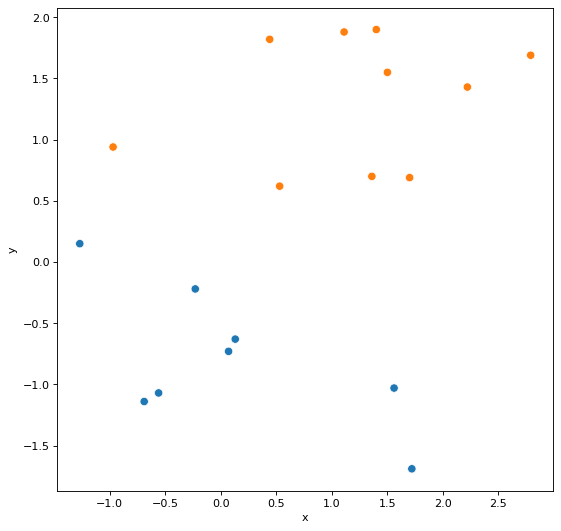

In [5]:
sns.scatterplot(x='x', y='y', hue='z', data=ex1, legend=False)
plt.show()

With a linear SVM model our goal is to identify the line (or a separating hyperplane in higher dimensions) with the largest possible margin. Like the other models we've already seen, we fit the SVM by constructing our feature matrix and outcome vector and then calling the `fit` method for our model object.

In [6]:
X_ex1 = ex1.drop('z', axis=1)
y_ex1 = ex1.z

When fitting the model we will only worry about two parameters for now: `kernel` which determines what if any kernel is used when calculating the dot product, and `C` which is the penalty for misclassification. These parameters default to `kernel='rbf'` for a radial basis function and `C=1`, we will change these to a `linear` kernel and a arbitrary large penalty respectively.

In [7]:
m = SVC(kernel='linear', C=10).fit(X_ex1, y_ex1)

Once fit we can visualize the decision boundary and the margins using the `plot_margin` function we defined above.

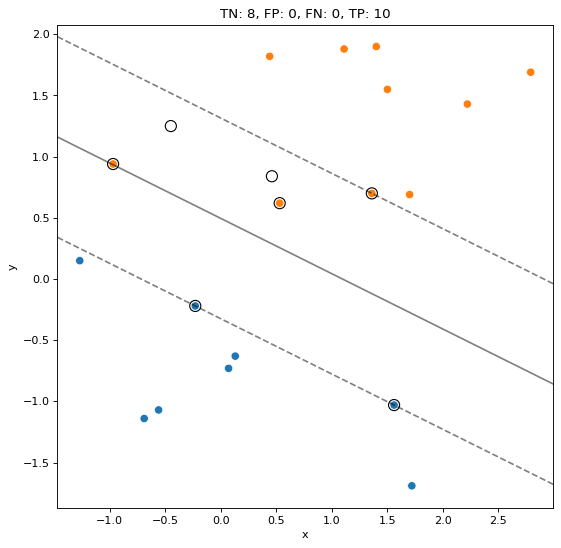

In [31]:
plot_margin(m, ex1)

The solid line is the separating hyperplane (line) and the dashed lines are the margins.

---

### &diams; Exercise 1

How many support vectors are there for this model?

---

We can explore how the penalty value affects this fit by setting up a simple function and interactive widget.

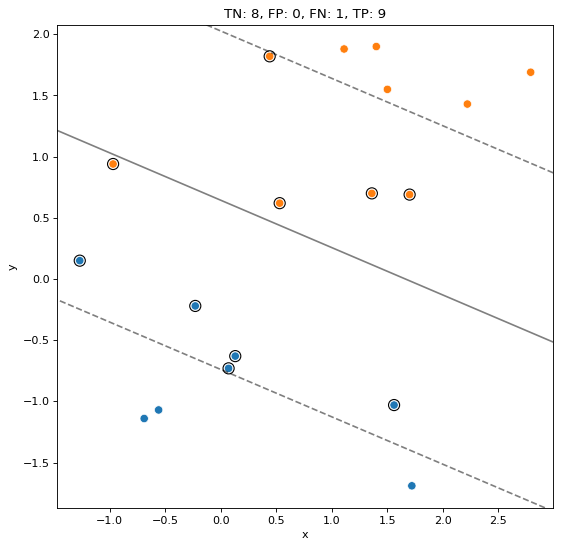

In [32]:
C = 0.1
m = SVC(kernel='linear', C=C).fit(X_ex1, y_ex1)
plot_margin(m, ex1)

---

### &diams; Exercise 2

How does the boundary line and the margins change as you change the value of `C`?

---

## 2.2 Example 2 - Non-separable data

We will not complicate our previous example somewhat by adding two additional points from the blue `A` class to our data. This is available in the `ex2.csv` file.

In [15]:
ex2 = pd.read_csv("ex2.csv")

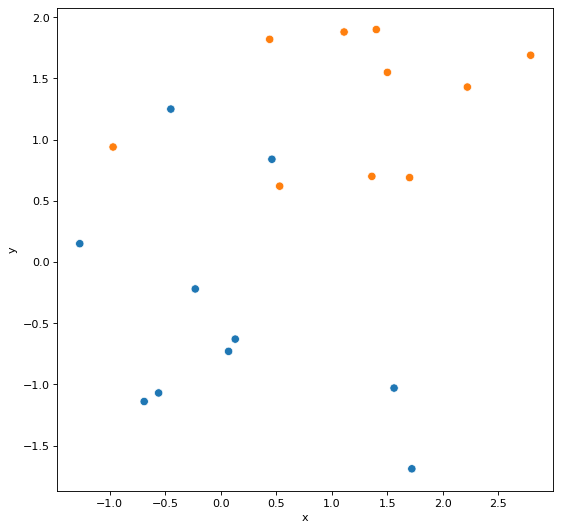

In [16]:
sns.scatterplot(x='x', y='y', hue='z', data=ex2, legend=False)
plt.show()

---

### &diams; Exercise 3

Are these two classes linearly separable?


---

We can again fit a `SVC` model to these data using the same code we used with example 1.

In [17]:
X_ex2 = ex2.drop('z', axis=1)
y_ex2 = ex2.z

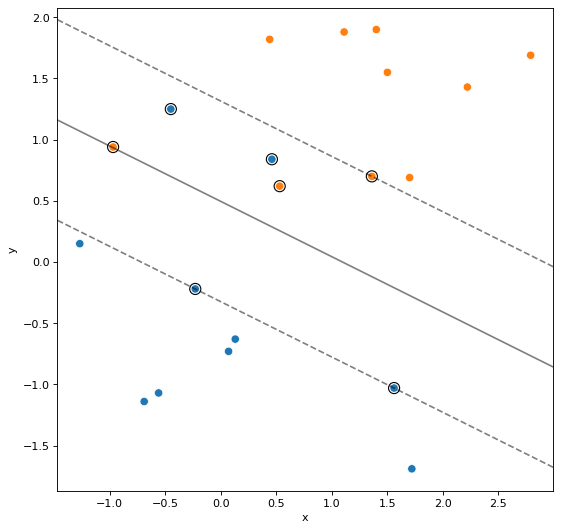

In [18]:
C = 10
m = SVC(kernel='linear', C=C).fit(X_ex2, y_ex2)
plot_margin(m, ex2)

---

### &diams; Exercise 4

How does the "fit" of this model differ compared to the "fit" for example 1. *Hint* - make your comparison for equivalent values of `C`.


---

### &diams; Exercise 5

How do the boundary line and margins change as you change the value of `C`?

---



## 2.3 Example 3 - A non-linear kernel

Next we will look at a new data set that would seem to also fall in the non-separable category. 

In [33]:
ex3 = pd.read_csv("ex3.csv")
X_ex3 = ex3.drop('z', axis=1)
y_ex3 = ex3.z

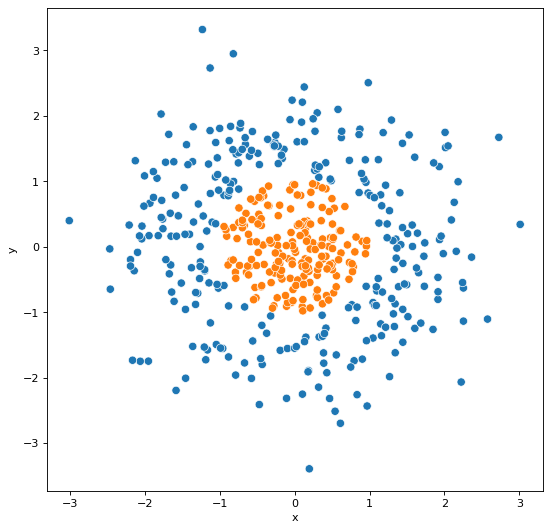

In [34]:
sns.scatterplot(x='x', y='y', hue='z', data=ex3, legend=False)
plt.show()

Clearly for these data there is no possible separating line that could come close to classifying these points. However, due to the kernel trick it is possible (and efficient) to project our data into a higher dimensional space where it may be possible to then define a separating hyperplane. For these data we will consider a simple polynomial kernel with degree 2. This kernel is defined as
$$ K(x,x') = (\gamma \langle x, x' \rangle + r)^d $$
where $\gamma$ is a scaling parameter, $d$ is the degree, and $r$ related to the intercept and is called `coef0` by sklearn. More details on the various kernels that can be used with the `SVC` model are available [here](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

The effect of using such a kernel is immediately obvious, as you can see in the interactive figure below.

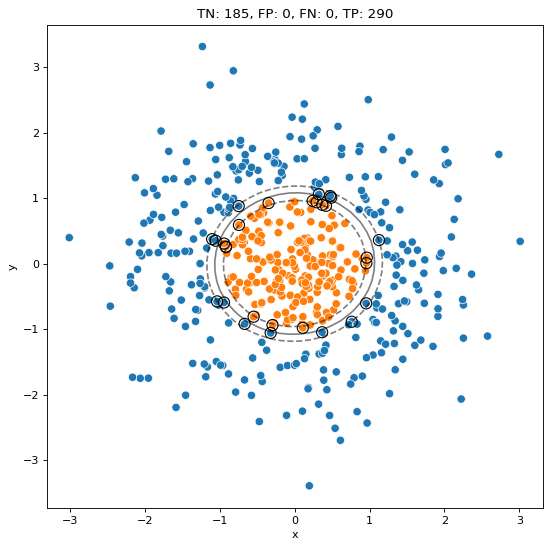

In [36]:
C = 10          # [1,2,5,7,10,20,50,100]
kernel = 'poly' # ['poly', 'linear']

m = SVC(kernel=kernel, degree=2, C=C, gamma='scale').fit(X_ex3, y_ex3)
plot_margin(m, ex3)

---

### &diams; Exercise 6

Compare the fit of the model using the polynomial and linear kernel. Describe the shape of the boundaries and the margins.


---

### &diams; Exercise 7

How do the boundary line and margins change as you change the value of `C`?

---



To better understand what is happening when we use a kernel with a SVM we can think about the kernel as projecting our data into a higher dimensional space - with this particular kernel we can think of it as adding a third dimension, proportional to $x^2+y^2$ to our data and then asking for the SVM model to find a separating *plane* in this 3-d space. We can crudely visualize this by creating this new dimension and plotting our data as a 3d scatter plot.

In [38]:
def plot_proj(elev=10, azim=45):
    colors = {'A':'#D37042', 'B':'#3D5DA1'}
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.scatter(ex3.x, ex3.y, (ex3.x**2 + ex3.y**2), c=ex3.z.apply(lambda x: colors[x]))
    
    ax.set_xlabel('x')
    ax.set_ylabel('y ')
    ax.set_zlabel('z ')
    
    plt.show()

You can adjust the values of `elev` and `azim` to adjust the "camera" position for the plot to get a better view of 

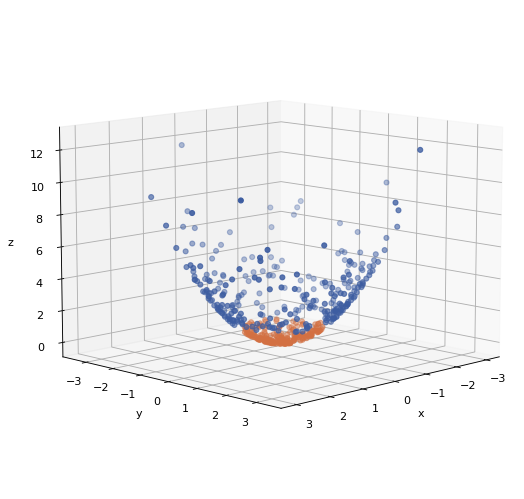

In [54]:
plot_proj(elev = 10, azim = 45)

---

### &diams; Exercise 8

As you adjust your view of the data via the elevation and azimuth, imagine a plane that could be used to separate these data into the two classes. If we were to project that plane back down to just `x` and `y`, what would its shape be?

---



## 2.4 Example 4 - Other Kernels

Next we will consider an even more complicated separation task where one class is split into two separate clusters by the second class. The data ara available as `ex4.csv`.

In [42]:
ex4 = pd.read_csv("ex4.csv")
X_ex4 = ex4.drop('z', axis=1)
y_ex4 = ex4.z

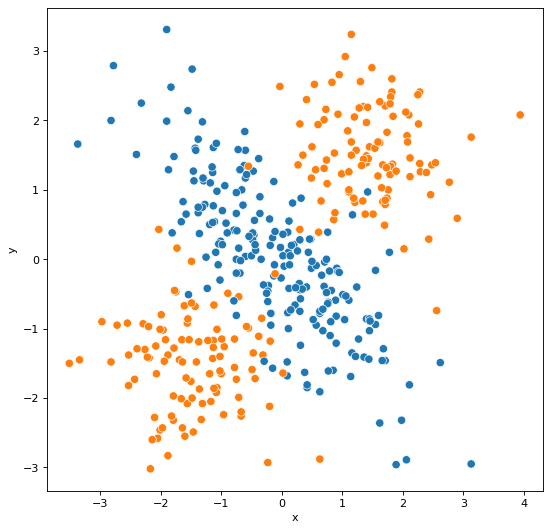

In [43]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='x', y='y', hue='z', data=ex4, legend=False)
plt.show()

Below we set up a similar interactive tool for experimenting with different penalties and kernel functions for these data. Note that the degree value is only used by polynomial kernel and is ignore by the linear and rbf kernels.

In [ ]:
C = 10      # [1,5,10,50,100],
degree = 2  # [2,3,4],
kernel = 'poly' # ['poly', 'rbf', 'linear'])

plt.figure(figsize=(8, 8))
m = SVC(kernel=kernel, degree=degree, C=C, gamma='scale').fit(X_ex4, y_ex4)
plot_margin(m, ex4)

---

### &diams; Exercise 9

What combination of parameters appears to produce the best fit? Is it easy to tell this by visual inspection alone?

---

### &diams; Exercise 10

How do the support vectors change as the kernel, penalty, and degree are changed?

---

## 2.5 Model Assessment

So far we have only inspected the various models by eye to get a sense of how well they fit our data. Since we are undertaking a classification task here we would like to be able to leverage the metrics and scoring tools we have already learned around logistic regression and related tools. The issue is that while we could generate a simple confusion matrix for our models' predictions this is somewhat limiting.

Let us consider the `rbf` model for example 4, we can fit this model and then explore what options we have.

In [44]:
m = SVC(kernel='rbf', C=1, gamma='scale').fit(X_ex4, y_ex4)

From this model we can report the accuracy, which is defined as
$$ \text{Accuracy} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{FP}+\text{TN}+\text{FN}} $$
using the `score` method. Similarly, if we want the confusion matrix or any other metric that can be calculated using the appropriate function and the `predict` method.

In [45]:
m.score(X_ex4, y_ex4)

0.945

In [46]:
sklearn.metrics.confusion_matrix(y_ex4, m.predict(X_ex4))

array([[192,   8],
       [ 14, 186]])

By default, SVM models do not support the construction of anything like a ROC curve since the predictions are not probabilistic - i.e. labels are assigned based on which side of the separator a point falls. As such, `SVC` models do not implement `predict_proba` by default.

In [ ]:
m.predict_proba(X_ex4)

As the error message suggests, we can obtain probabilistic predictions for each observation by setting `probability=True` before fitting our model. Details on what is involved in this process are provided in the sklearn user guide [here](https://scikit-learn.org/stable/modules/svm.html#scores-probabilities). Generally, if probabilistic predictions are needed then an alternative modelling method is likely to be superior.

With the available scoing metrics we can make use of the usual cross valiation tools such as `cross_val_score` which can be useful for the purpose of comparing different models,

In [49]:
rbf = sklearn.model_selection.cross_val_score(
    SVC(kernel='rbf', C=1, gamma='scale'), 
    X_ex4, y_ex4, 
    cv=KFold(5, shuffle=True, random_state=1234)
)

print(rbf)
print(rbf.mean())

[0.925  0.975  0.9125 0.975  0.925 ]
0.9425000000000001


In [50]:
poly = sklearn.model_selection.cross_val_score(
    SVC(kernel='poly', degree=2, C=1, gamma='scale'), 
    X_ex4, y_ex4, 
    cv=KFold(5, shuffle=True, random_state=1234)
)

print(poly)
print(poly.mean())

plot_margin(poly, ex4)

[0.9375 0.975  0.8875 0.95   0.925 ]
0.9349999999999999


In [51]:
poly

array([0.9375, 0.975 , 0.8875, 0.95  , 0.925 ])

Which indicates that the rbf appears to slightly outperform the degree 2 polynomial, but only for `C=1`. 

---

### &diams; Exercise 11

If you adjust `C` are you able to find a better performing version of either the `rbf` or `poly` SVM models?

---

### &diams; Exercise 12

Construct a full cross validated grid search over the parameter values: `C = [1,5,10,50,100]`,`degree = [2,3,4]`, and `kernel = ['poly', 'rbf', 'linear']`. Which SVM model performs best? Use `plot_margin` to show the resulting seperator and support vectors.

---

# 2.6. Additional Reading

The sklearn [user guide for SVM models](https://scikit-learn.org/stable/modules/svm.html) is particularly good compared to some of the others we have see so far. I suggets browsing through it as a good overview of the modeling method in addition to what has been covered in lecture. Specifically, I would also like to highly recommend section [1.4.5 Tips on Practical Use](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use) has excellent guidance on usage of these models.


---

## 3. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week08` assignment.

In [ ]:
!jupyter nbconvert --to pdf mlp-week08.ipynb